# ML Project : NYC Yellow taxi price prediction

Across New York City, thousands of people step into yellow taxis every day, relying on them to navigate the busy streets quickly and efficiently. Yet the final fare can vary widely from one trip to another, depending on a mix of geographic, temporal, and environmental conditions. With this in mind, our goal is to investigate whether we can use available data and predictive modeling techniques to estimate taxi fares more accurately, ultimately providing insights that could benefit both riders and drivers.

We will be using the following dataset to make train our model : https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data

In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline


from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

from sklearn.cluster import MiniBatchKMeans
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

import warnings
warnings.filterwarnings("ignore")

# Step 1: Import data

In [6]:
# import dataset
df = pd.read_csv(r'yellow_tripdata_2015-01.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


# Step 2: Clean the data

### 2.1) Change datatype

In [9]:
# One-hot encode 
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].map(lambda x: 0 if x=='N' else 1)

In [10]:
# Convert time to timestamps
format_code = "%Y-%m-%d %H:%M:%S"

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format=format_code)
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format=format_code)

### 2.2) Drop Missing values
We have decided to drop instead of replace the missing values as there are only 3 out of 12M+ rows

In [12]:
df = df.dropna()

In [13]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

### 2.3) Remove outliers

In [15]:
# Remove negative distances
df = df[df["trip_distance"] > 0]

In [16]:
df = df[df['fare_amount'] > 0 ]

In [17]:
df = df[df['passenger_count']>0]

In [18]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(25/100)
    Q3 = df[column].quantile(75/100)
    IQR = Q3 - Q1
    
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    
    df_clean = df[(df[column] >= lim_inf) & (df[column] <= lim_sup)]
    return df_clean

In [19]:
#for x in df.columns:
    #df = remove_outliers(df, x)

In [20]:
len(df)

12658407

### 2.4) Sample the DataFrame
Since our dataset has more than 12 million rows, we need break our DataFrame into smaller pieces so that we can train on it and then scale upwards

In [22]:
def sample_uniform_by_day(
    df: pd.DataFrame,
    datetime_col: str = "tpep_pickup_datetime",
    n_per_day: int | None = None,
    frac_per_day: float | None = None,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Samples uniformly at random within each day.
- Choose either `n_per_day` (fixed number of rows per day) or `frac_per_day` (fraction per day).
- If `n_per_day` > size of a given day, take all rows from that day.
    """
    if (n_per_day is None) == (frac_per_day is None):
        raise ValueError("Spécifie exactement l'un de `n_per_day` ou `frac_per_day`.")

    # Make sure the time column is set to datetime
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")
    df = df.dropna(subset=[datetime_col])

    # Key ‘date’ (calendar day) from the time of pick-up
    df["_date"] = df[datetime_col].dt.date

    if n_per_day is not None:
        # Sampling with a fixed number per day (without replacement)
        out = (
            df.groupby("_date", group_keys=False)
              .apply(lambda g: g.sample(n=min(n_per_day, len(g)),
                                        replace=False,
                                        random_state=random_state))
        )
    else:
         # Sampling with one fraction per day
        out = (
            df.groupby("_date", group_keys=False)
              .apply(lambda g: g.sample(frac=frac_per_day,
                                        replace=False,
                                        random_state=random_state))
        )

    return out.drop(columns=["_date"])

# Step 3: Feature Engineering

Text(0, 0.5, 'Average Fare')

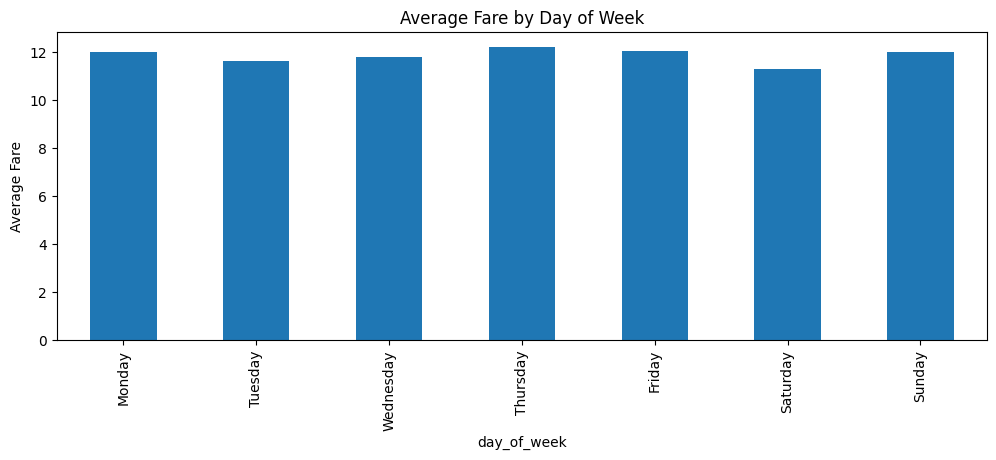

In [71]:
# Create pickup date -> Only keeps the date and not the time 
df["pickup_date"] = df["tpep_pickup_datetime"].dt.date

# Make 'pickup_date' to a datetime object
df['pickup_date'] = pd.to_datetime(df['pickup_date'], format=format_code)

# Extract the name of the day
df['day_of_week'] = df['pickup_date'].dt.day_name()

# Compute average fare per day of week
avg_fare_amount_per_day_of_week = (
    df.groupby('day_of_week')['fare_amount'].mean().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    )
)

# Plot
avg_fare_amount_per_day_of_week.plot(kind='bar', figsize=(12, 4), title='Average Fare by Day of Week')

plt.ylabel('Average Fare')

In [72]:
# Check if midnight is 0 or 00
df['tpep_pickup_datetime'].dt.hour.min()

0

In [73]:
# Categorize the different moments of a day (early morning, morning, noon/afternoon, night)

def map_moments_of_day(x):
    if x.hour in range(0,6):
        return "early morning"
    elif x.hour in range(6, 13):
        return 'morning'
    elif x.hour in range(13, 16):
        return 'noon/afternoon'
    elif x.hour in range(16,21):
        return 'rush hour'
    else:
        return "night"

In [74]:
# Create a column moments of day
df['Moments_of_day'] = df['tpep_pickup_datetime'].apply(map_moments_of_day)

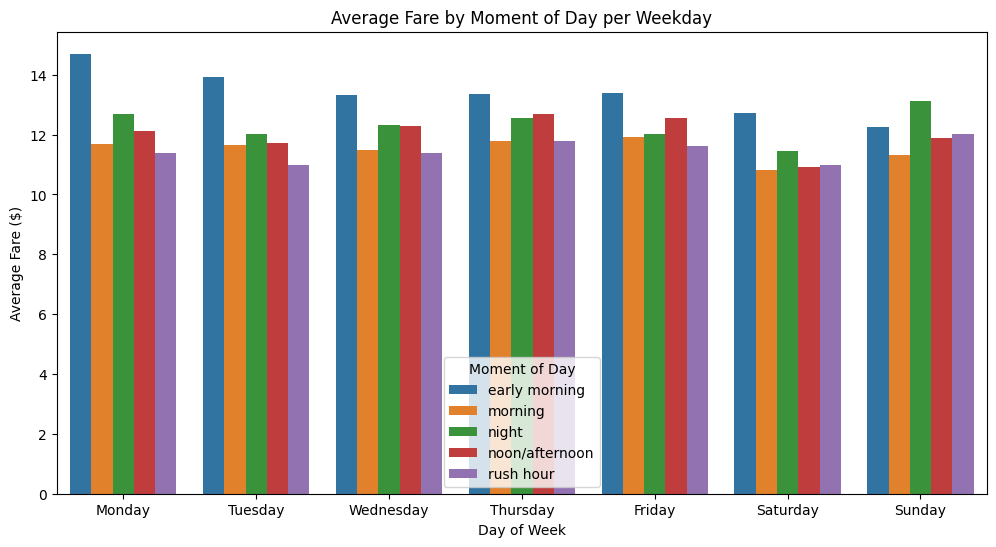

In [75]:
# Plot the average fare of the moments of the day per day of 

# Aggregate fare_amount mean by the day of the week and the moment of the day 
avg_fare = df.groupby(['day_of_week', 'Moments_of_day'], observed=False)['fare_amount'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.barplot(
    data=avg_fare,
    x='day_of_week',
    y='fare_amount',
    hue='Moments_of_day',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # For a more comprehensible visualisation
)

plt.title('Average Fare by Moment of Day per Weekday')
plt.ylabel('Average Fare ($)')
plt.xlabel('Day of Week')
plt.legend(title='Moment of Day')
plt.show()

<Axes: xlabel='day_of_week', ylabel='fare_amount'>

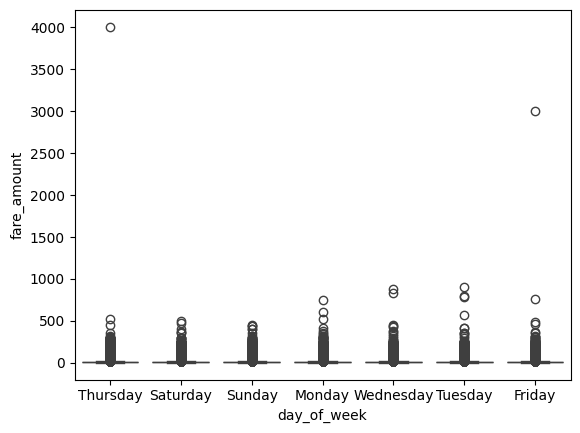

In [76]:
# Look at the distributions of the fares per day
sns.boxplot(x='day_of_week', y='fare_amount', data=df)

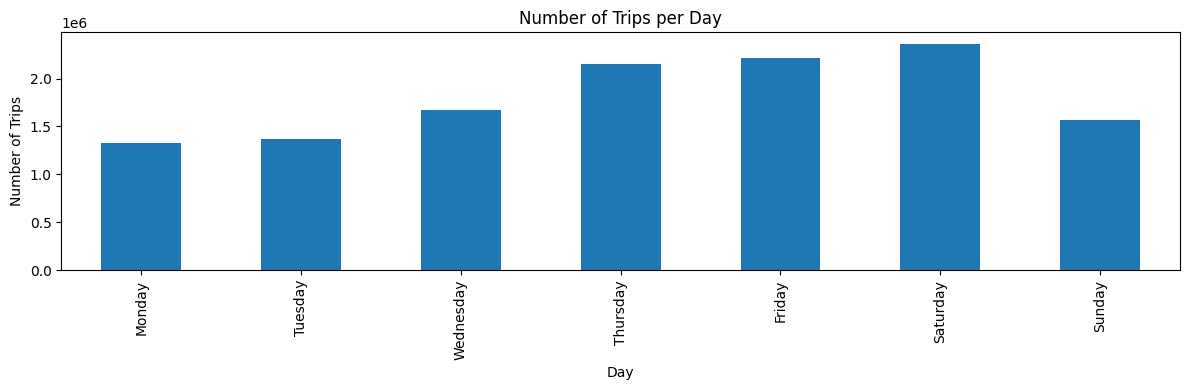

In [77]:
# Define the correct order
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert to an ordered categorical
df["day_of_week"] = pd.Categorical(df["day_of_week"], categories=ordered_days, ordered=True)

# Now group and plot again
trips_per_day = df.groupby('day_of_week', observed=False).size()

trips_per_day.plot(kind="bar", figsize=(12,4))
plt.title("Number of Trips per Day")
plt.xlabel("Day")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


In [78]:
# Create time duration feature
df['duration_in_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [79]:
# Create average speed (mph) feature
df["avg_speed"] = 60*(df["trip_distance"]/df["duration_in_min"]) #in mph

In [80]:
#!pip install geopy

In [81]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def find_clusters_kmeans(df, lon_col, lat_col, new_cluster_col, n_clusters=100):
    print(f"Clustering de '{new_cluster_col}' en {n_clusters} zones...")
    
    
    coords_df = df[[lon_col, lat_col]].dropna()
    coords_np = coords_df.values
    
    # Training Step
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048, n_init='auto')
    kmeans.fit(coords_np)
    
    
    labels = kmeans.predict(coords_np)
    
    df_clustered = df.copy()
    df_clustered[new_cluster_col] = -1
    df_clustered.loc[coords_df.index, new_cluster_col] = labels
    df_clustered[new_cluster_col] = df_clustered[new_cluster_col].astype(int)
    

    return df_clustered, kmeans


# Clustering 
df, pickup_model = find_clusters_kmeans(
    df, 
    'pickup_longitude', 'pickup_latitude', 
    'Pickup_Cluster', 
    n_clusters=100
)


coords_dropoff = df[['dropoff_longitude', 'dropoff_latitude']].dropna()
labels_dropoff = pickup_model.predict(coords_dropoff.values)

df['Dropoff_Cluster'] = -1
df.loc[coords_dropoff.index, 'Dropoff_Cluster'] = labels_dropoff
df['Dropoff_Cluster'] = df['Dropoff_Cluster'].astype(int)

print("Clustering Done!")

# GEO API 

from geopy.exc import GeocoderTimedOut, GeocoderUnavailable


geolocator = Nominatim(user_agent="nyc_taxi_project_student_final_v3", timeout=5)
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1.5)

cluster_centers = pickup_model.cluster_centers_ 
cluster_names = {}

for cluster_id, coords in enumerate(cluster_centers):
    lon, lat = coords 
    
    
    lat = float(lat)
    lon = float(lon)

    try:
        location = geocode((lat, lon), language='en')
        
        if location:
            address = location.raw.get('address', {})
            neigh = address.get('neighbourhood', address.get('hamlet', address.get('quarter', 'Unknown')))
            borough = address.get('suburb', address.get('city_district', address.get('borough', 'Unknown')))
            cluster_names[cluster_id] = {'Neighbourhood': neigh, 'Borough': borough}
        else:
            cluster_names[cluster_id] = {'Neighbourhood': 'Unknown', 'Borough': 'Unknown'}
            
    except (GeocoderTimedOut, GeocoderUnavailable):
    
        
        cluster_names[cluster_id] = {'Neighbourhood': 'Error', 'Borough': 'Error'}
    except Exception as e:
        cluster_names[cluster_id] = {'Neighbourhood': 'Error', 'Borough': 'Error'}
        
    if cluster_id % 10 == 0: 
        print(f"  - Zone {cluster_id}/100 traitée...")
        continue


print("Fusion des noms dans le DataFrame...")
df_zones = pd.DataFrame.from_dict(cluster_names, orient='index').reset_index()
df_zones.columns = ['Cluster_ID', 'Neighbourhood', 'Borough']

#Now adjusting pickup and dropoff columns using actual locations based on coords
df = df.merge(
    df_zones.rename(columns={'Cluster_ID': 'Pickup_Cluster', 'Neighbourhood': 'Pickup_Neighbourhood', 'Borough': 'Pickup_Borough'}),
    on='Pickup_Cluster', how='left'
)

df = df.merge(
    df_zones.rename(columns={'Cluster_ID': 'Dropoff_Cluster', 'Neighbourhood': 'Dropoff_Neighbourhood', 'Borough': 'Dropoff_Borough'}),
    on='Dropoff_Cluster', how='left'
)
print("Done")

Clustering de 'Pickup_Cluster' en 100 zones...
Clustering Done!
  - Zone 0/100 traitée...
  - Zone 10/100 traitée...
  - Zone 20/100 traitée...
  - Zone 30/100 traitée...
  - Zone 40/100 traitée...
  - Zone 50/100 traitée...
  - Zone 60/100 traitée...
  - Zone 70/100 traitée...
  - Zone 80/100 traitée...
  - Zone 90/100 traitée...
Fusion des noms dans le DataFrame...
Done


In [82]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,day_of_week,Moments_of_day,duration_in_min,avg_speed,Pickup_Cluster,Dropoff_Cluster,Pickup_Neighbourhood,Pickup_Borough,Dropoff_Neighbourhood,Dropoff_Borough
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,0,-73.974785,...,Thursday,rush hour,18.050000,5.285319,62,34,Chelsea District,Manhattan,Tudor City,Manhattan
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,0,-73.994415,...,Saturday,rush hour,19.833333,9.983193,11,91,SoHo,Manhattan,Manhattan Community Board 4,Manhattan
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,0,-73.951820,...,Saturday,rush hour,10.050000,10.746269,64,81,Manhattan Valley,Manhattan,Manhattan Community Board 10,Manhattan
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,0,-74.004326,...,Saturday,rush hour,1.866667,16.071429,26,74,Tribeca,Manhattan,Hudson Square,Manhattan
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,0,-74.004181,...,Saturday,rush hour,19.316667,9.318378,41,0,Manhattan Community Board 5,Manhattan,Chelsea District,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12658402,1,2015-01-10 19:01:44,2015-01-10 19:05:40,2,1.00,-73.951988,40.786217,1,0,-73.953735,...,Saturday,rush hour,3.933333,15.254237,31,3,Carnegie Hill,Manhattan,Yorkville,Manhattan
12658403,1,2015-01-10 19:01:44,2015-01-10 19:07:26,2,0.80,-73.982742,40.728184,1,0,-73.974976,...,Saturday,rush hour,5.700000,8.421053,48,37,East Village,Manhattan,Alphabet City,Manhattan
12658404,1,2015-01-10 19:01:44,2015-01-10 19:15:01,1,3.40,-73.979324,40.749550,1,0,-73.969101,...,Saturday,rush hour,13.283333,15.357591,65,99,Manhattan Community Board 5,Manhattan,Manhattan Community Board 7,Manhattan
12658405,1,2015-01-10 19:01:44,2015-01-10 19:17:03,1,1.30,-73.999565,40.738483,1,0,-73.981819,...,Saturday,rush hour,15.316667,5.092492,72,93,Union Square,Manhattan,Gramercy,Manhattan


### Step 3) Preparing data for training

In [84]:
df = df[(df['duration_in_min']<120) & (df['duration_in_min']>1)]

In [265]:
# Transform day_of_week into numerical values
df.loc[:,'day_of_week'] = df['day_of_week'].cat.codes

AttributeError: Can only use .cat accessor with a 'category' dtype

In [267]:
# Make moments of day into numerical 
dic_moments_of_day = { 'early morning' : 0, "morning" : 1, 'noon/afternoon': 2, 'night': 3, 'rush hour': 4}
df['Moments_of_day'] = df['Moments_of_day'].map(dic_moments_of_day)

In [87]:
# Columns to normalize (take into account that this is for random forest)
columns_to_normalize_rf = ['trip_distance', 'tolls_amount']

In [88]:
# Columns to drop
# Practically constant feature : mta_tax
# Unuseful information on its own: datetime type columns and coordinates and tips + total_fare as we are prediction the fare amount and not the total fare amount
# Features that don't really have an impact on the fare : VendorID
columns_to_drop_rf = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'mta_tax', "pickup_longitude", 'pickup_latitude', "dropoff_longitude", 'dropoff_latitude', 
                      'tip_amount', 'total_amount', 'pickup_date', "avg_speed", "VendorID", "Pickup_Neighbourhood",
                      "Dropoff_Neighbourhood","Pickup_Borough","Dropoff_Borough", 'RateCodeID', 'store_and_fwd_flag', 'extra', 'tolls_amount','improvement_surcharge',
                      'fare_amount']

In [89]:
#Drop the unneeded colulmns
df_rf = df.drop(columns=columns_to_drop_rf)

In [90]:
# Normalize using MinMax scaler
columns_to_normalize_rf = ['trip_distance', 'tolls_amount']
scaler = MinMaxScaler()
for col in columns_to_normalize_rf:
    if col in df_rf.columns:
        df_rf[[col]] = scaler.fit_transform(df_rf[[col]])

In [91]:
# Define X and y (target label)
X = df_rf.drop(labels = 'duration_in_min', axis=1)
y = df_rf['duration_in_min']

In [92]:
X

,passenger_count,trip_distance,payment_type,day_of_week,Moments_of_day,Pickup_Cluster,Dropoff_Cluster
0,1,1.024643e-07,1,3,4,62,34
1,1,2.133592e-07,1,5,4,11,91
2,1,1.160830e-07,2,5,4,64,81
3,1,3.177690e-08,2,5,4,26,74
4,1,1.939040e-07,2,5,4,41,0
...,...,...,...,...,...,...,...
12658402,2,6.420232e-08,1,5,4,31,3
12658403,2,5.123215e-08,1,5,4,48,37
12658404,1,2.198443e-07,2,5,4,65,99
12658405,1,8.365756e-08,1,5,4,72,93


In [93]:
y

0           18.050000
1           19.833333
2           10.050000
3            1.866667
4           19.316667
              ...    
12658402     3.933333
12658403     5.700000
12658404    13.283333
12658405    15.316667
12658406     5.800000
Name: duration_in_min, Length: 12607677, dtype: float64

In [94]:
len(X)

12607677

In [95]:
X.dtypes

passenger_count      int64
trip_distance      float64
payment_type         int64
day_of_week           int8
Moments_of_day       int64
Pickup_Cluster       int32
Dropoff_Cluster      int32
dtype: object

In [96]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
def show_results(y_test, y_pred):
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'rmse : {rmse}')
    print(f'mae : {mae}')
    print(f'r2 : {r2}')
    

In [98]:
def get_results(y_test, y_pred):
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    dic = {"rmse": rmse, "mae": mae, "r2": r2}
    return dic

# Step 4: Model Training

## Step 1: Time prediction

In [101]:
from catboost import CatBoostRegressor

In [102]:
# Create catboost model
model_catboost = CatBoostRegressor(verbose=0,
                                   thread_count=-1,
                                   random_state=42,
                                  )

In [103]:
# Fit and train
model_catboost.fit(X_train, y_train)

y_pred_catboost = model_catboost.predict(X_test)

In [104]:
# Evaluate 
show_results(y_test, y_pred_catboost)

rmse : 4.304549620570571
mae : 2.7284026283324185
r2 : 0.7769782213094186


In [105]:
df_rf['duration_in_min'] = model_catboost.predict(X)

In [106]:
# Define X and y (target label)
X = df_rf
y = df['fare_amount']

In [107]:
X

,passenger_count,trip_distance,payment_type,day_of_week,Moments_of_day,duration_in_min,Pickup_Cluster,Dropoff_Cluster
0,1,1.024643e-07,1,3,4,12.046013,62,34
1,1,2.133592e-07,1,5,4,19.267017,11,91
2,1,1.160830e-07,2,5,4,9.344780,64,81
3,1,3.177690e-08,2,5,4,3.535264,26,74
4,1,1.939040e-07,2,5,4,18.002845,41,0
...,...,...,...,...,...,...,...,...
12658402,2,6.420232e-08,1,5,4,5.385157,31,3
12658403,2,5.123215e-08,1,5,4,6.374179,48,37
12658404,1,2.198443e-07,2,5,4,16.422162,65,99
12658405,1,8.365756e-08,1,5,4,9.050110,72,93


In [108]:
y

0           12.0
1           14.5
2            9.5
3            3.5
4           15.0
            ... 
12658402     5.5
12658403     6.0
12658404    13.5
12658405    10.5
12658406     5.5
Name: fare_amount, Length: 12607677, dtype: float64

In [109]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [110]:
X_train

,passenger_count,trip_distance,payment_type,day_of_week,Moments_of_day,duration_in_min,Pickup_Cluster,Dropoff_Cluster
10173567,1,8.625160e-08,1,0,4,7.923420,69,20
3077601,1,1.355382e-07,1,2,3,9.647025,20,59
8104101,1,3.177690e-08,2,4,3,3.105251,68,74
2951049,1,4.474707e-08,1,4,4,5.834181,57,48
6220787,1,1.063554e-07,2,6,2,9.874472,69,51
...,...,...,...,...,...,...,...,...
2243500,2,6.024642e-07,1,4,0,18.725893,2,69
4321895,1,1.095979e-07,2,2,1,12.362528,45,87
10121866,1,1.472114e-07,1,5,4,11.126026,78,31
6576808,1,1.115434e-07,1,4,2,12.286790,50,15


## Step 2: Fare prediction

### 4.1) RandomForestRegressor

In [113]:
# Create RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 50,random_state=42, verbose=1, n_jobs=-1)

In [114]:
# Train RandomForest
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.6min finished


RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42, verbose=1)

In [115]:
# Test Model
y_pred_rf = rf.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   49.5s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:  1.5min finished


In [116]:
# Show results
show_results(y_test, y_pred_rf)

rmse : 3.066146457810401
mae : 1.2229637200096264
r2 : 0.9020492383525741


### 4.2 ) XGBoost

In [118]:
import xgboost as xgb

In [119]:
#!pip install xgboost

In [120]:

# Create xgb model
xg_reg = xgb.XGBRegressor(
    n_estimators=50,         
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      
    enable_categorical=True, 
    # verbosity=1            
)


In [121]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=-1, num_parallel_tree=None, ...)

In [122]:
y_pred_xg = xg_reg.predict(X_test)

In [123]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

show_results(y_test, y_pred_xg)

rmse : 3.0288971887318095
mae : 1.1204259206648264
r2 : 0.9044147037605812


### 4.3 ) Linear Regression

In [125]:
"""

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# 1. Définition X et y
X = df_rf.drop(labels='fare_amount', axis=1)
y = df_rf['fare_amount']


cats_columns = X.select_dtypes(include=['object', 'category']).columns

# On applique le One-Hot Encoding sur ces colonnes
# drop_first=True est OBLIGATOIRE pour éviter la multicolinéarité en régression linéaire
# dtype=int permet d'avoir des 0 et 1 au lieu de False/True
X = pd.get_dummies(X, columns=cats_columns, drop_first=True, dtype=int)

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"Nouvelle taille de X après encodage : {X.shape}") 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


lr = LinearRegression(n_jobs=-1)

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

# 6. Évaluation
rmse = mean_squared_error(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f'rmse : {rmse}')
print(f'mae  : {mae}')
print(f'r2   : {r2}')

"""

'\n\nimport pandas as pd\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.impute import SimpleImputer\n\n# 1. Définition X et y\nX = df_rf.drop(labels=\'fare_amount\', axis=1)\ny = df_rf[\'fare_amount\']\n\n\ncats_columns = X.select_dtypes(include=[\'object\', \'category\']).columns\n\n# On applique le One-Hot Encoding sur ces colonnes\n# drop_first=True est OBLIGATOIRE pour éviter la multicolinéarité en régression linéaire\n# dtype=int permet d\'avoir des 0 et 1 au lieu de False/True\nX = pd.get_dummies(X, columns=cats_columns, drop_first=True, dtype=int)\n\nimputer = SimpleImputer(strategy=\'median\')\nX = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)\n\nprint(f"Nouvelle taille de X après encodage : {X.shape}") \n\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)\n\n\nlr = LinearReg

### 4.4) LightGBM

In [127]:
#!pip install lightgbm

In [128]:

import lightgbm 
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor()

model_lgbm.fit(X_train, y_train)

y_pred_lgbm = model_lgbm.predict(X_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 2521535, number of used features: 8
[LightGBM] [Info] Start training from score 11.865980


In [129]:
# Evaluate 
show_results(y_test, y_pred_lgbm)

rmse : 2.996490382075371
mae : 1.1153047245027545
r2 : 0.9064491361035631


### 4.5) CatBoost

In [131]:
from catboost import CatBoostRegressor

In [132]:
# Create catboost model
model_catboost = CatBoostRegressor(verbose=0,
                                   thread_count=-1,
                                   random_state=42,
                                  )

In [133]:
# Fit and train
model_catboost.fit(X_train, y_train)

y_pred_catboost = model_catboost.predict(X_test)

In [134]:
# Evaluate 
show_results(y_test, y_pred_catboost)

rmse : 3.0047282040117356
mae : 1.1113118877924575
r2 : 0.9059340570700367


### 4.6) Compare baselines

In [136]:
rf_baseline = get_results(y_test, y_pred_rf) 
xg_baseline = get_results(y_test, y_pred_xg)
lgbm_baseline = get_results(y_test, y_pred_lgbm)
catboost_baseline = get_results(y_test, y_pred_catboost)

baseline_results = pd.DataFrame(data = [rf_baseline, xg_baseline, lgbm_baseline, catboost_baseline])

In [137]:
# Define the model names
model_names = ['Random Forest Regressor', 'XGBoost', 'LightGBM', "CatBoost"]
# Change index to name of models
baseline_results.index = model_names

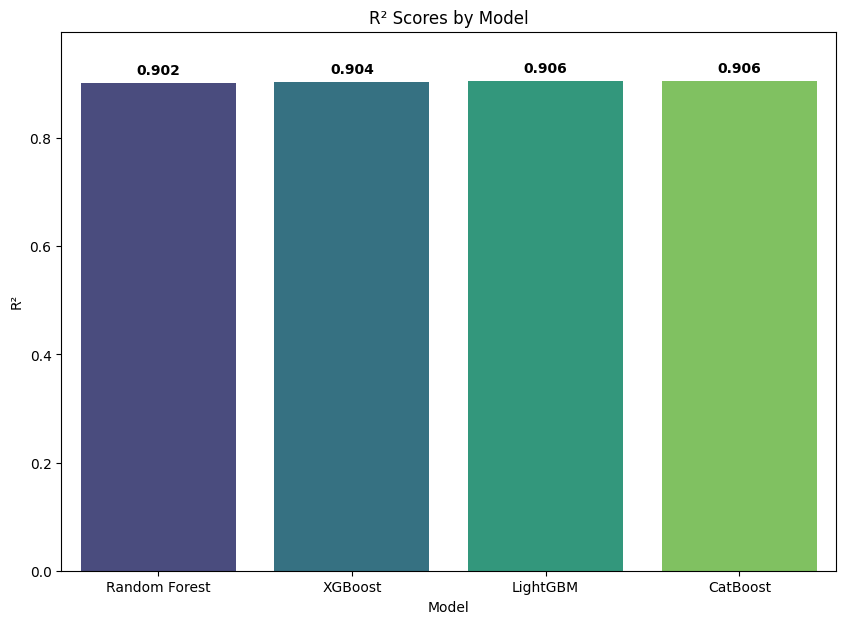

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add model names to the DataFrame
baseline_results['model'] = ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']

# Create the bar plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='model', y='r2', data=baseline_results, palette='viridis')

# Annotate each bar with the R² score
for bar in ax.patches:
    height = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    ax.text(
        x_pos, 
        height + 0.01, 
        f"{height:.3f}", 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )

# Labels and title
plt.title('R² Scores by Model')
plt.xlabel('Model')
plt.ylabel('R²')
plt.ylim(0, 1.1 * baseline_results['r2'].max())  # add some space above bars

plt.show()


## Step 5) Hyperparameter tuning

In [140]:
from sklearn.model_selection import RandomizedSearchCV

In [141]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train, y_train, test_size=0.97,
                                                                                random_state=42)

In [142]:
len(X_train_sample)

75646

### 5.1) GridSearchCV

### 5.1.1) RandomForest

In [145]:
# Define the hyperparameter's Grid to be tested
param_grid_rf = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [10, 20, 30, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

In [146]:
Grid_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,  
    n_iter=15,                             
    cv=3,
    verbose=3,
    #n_jobs=2
)

Grid_search_rf.fit(X_train_sample, y_train_sample)  


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100;, score=0.882 total time=   3.3s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100;, score=0.871 total time=   3.0s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100;, score=0.863 total time=   3.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.919 total time=   4.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.905 total time=   4.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.899 total time=   4.0s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=6, min_samples_split=2, n_estimators=200;, score=0.910 total time=   3.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=6, min_samples_split=2, n_estimators=200;, score=0.895 total time=  11.0s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=6, min_samples_split=2, n_estimators=200;, score=0.895 total time=   3.8s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.919 total time=   1.3s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.905 total time=   1.4s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.897 total time=   1.3s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.872 total time=   7.1s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.852 total time=   7.2s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.836 total time=   7.3s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.872 total time=   2.1s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.852 total time=   2.1s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.836 total time=   2.0s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.885 total time=   1.8s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.868 total time=   1.8s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.861 total time=   1.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.874 total time=   3.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.862 total time=   3.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.858 total time=   3.9s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=6, min_samples_split=10, n_estimators=200;, score=0.882 total time=   5.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=6, min_samples_split=10, n_estimators=200;, score=0.871 total time=   5.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=6, min_samples_split=10, n_estimators=200;, score=0.863 total time=   5.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.908 total time=   0.8s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.896 total time=   0.8s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.892 total time=   0.8s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.919 total time=   4.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.905 total time=   4.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.899 total time=   4.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.915 total time=   2.2s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.899 total time=   2.1s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.898 total time=   2.3s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.920 total time=   4.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.906 total time=   5.0s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.899 total time=   4.7s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.870 total time=   7.2s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.850 total time=   7.0s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.835 total time=   7.1s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.851 total time=   7.3s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.830 total time=   7.2s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.830 total time=   7.3s


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.1s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_estimators=50, n_jobs=-1,
                                                   random_state=42, verbose=1),
                   n_iter=15,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   verbose=3)

In [147]:
# Get best params
Grid_search_rf.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 30,
 'bootstrap': True}

Having 200 n_estimators is unfortunately takes too much space in the memory so we are obliged to reduce it to 50 for the model to be able to run

In [236]:
# Change n_estimators to 50
Grid_search_rf.best_params_['n_estimators'] = 50

In [224]:
# Create new RandomForestRegressor model with optimized parameters
opti_rf = RandomForestRegressor(n_jobs=-1,**Grid_search_rf.best_params_)

In [226]:
# fit on train_test_split
opti_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=2, n_estimators=50,
                      n_jobs=-1)

In [227]:
# Make predictions
y_pred_rf_opti = opti_rf.predict(X_test)

In [228]:
# Show new results
show_results(y_test, y_pred_rf_opti)

rmse : 3.022972384744342
mae : 1.196603201369875
r2 : 0.9047882854424661


### 5.1.2) LGBM Regressor

In [170]:
param_grid_lgbm = {
    'n_estimators': [200, 500],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [64, 128, 256],
    'max_depth': [10, -1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_samples': [20, 50],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}


In [172]:
# Launch the Grid Search 
Grid_search_lgbm = RandomizedSearchCV(estimator = model_lgbm, 
                                      param_distributions = param_grid_lgbm, 
                                      n_iter=15,
                                      #n_jobs=8, 
                                      cv=3,
                                      verbose = 3
)

In [174]:
# Fit the gridsearch
Grid_search_lgbm.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 50430, number of used features: 8
[LightGBM] [Info] Start training from score 11.858932
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=200, num_leaves=256, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=0.925 total time=   2.2s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 50431, number of us

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_iter=15,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [10, -1],
                                        'min_child_samples': [20, 50],
                                        'n_estimators': [200, 500],
                                        'num_leaves': [64, 128, 256],
                                        'reg_alpha': [0, 0.1],
                                        'reg_lambda': [0, 0.1],
                                        'subsample': [0.8, 1.0]},
                   verbose=3)

In [175]:
# Get best params
Grid_search_lgbm.best_params_

{'subsample': 1.0,
 'reg_lambda': 0,
 'reg_alpha': 0,
 'num_leaves': 64,
 'n_estimators': 200,
 'min_child_samples': 50,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

In [176]:
# Create new model with optimized parameters
opti_lgbm = LGBMRegressor(n_jobs=-1, **Grid_search_lgbm.best_params_)

In [177]:
# Fit on train_test_split
opti_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 2521535, number of used features: 8
[LightGBM] [Info] Start training from score 11.865980


LGBMRegressor(max_depth=10, min_child_samples=50, n_estimators=200, n_jobs=-1,
              num_leaves=64, reg_alpha=0, reg_lambda=0)

In [178]:
# Make predictions
y_pred_opti_lgbm = opti_lgbm.predict(X_test)

In [179]:
# Show new results
show_results(y_test, y_pred_opti_lgbm)

rmse : 2.978866543285934
mae : 1.1046917404630319
r2 : 0.9075463375963742


### 5.1.3) XGBoost

In [187]:
param_grid_xgb = {
    'n_estimators': [300, 500],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [10, 30]
}


In [189]:
# Launch the Grid Search 
Grid_search_xgb = RandomizedSearchCV(estimator = xg_reg, 
                                     param_distributions = param_grid_xgb,
                                     n_iter = 15,
                                     #n_jobs=8, 
                                     cv=3,  
                                     verbose=3)


In [191]:
# Fit the gridsearch
Grid_search_xgb.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.8;, score=0.926 total time=   1.8s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.8;, score=0.909 total time=   1.7s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.8;, score=0.908 total time=   1.4s
[CV 1/3] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=30, n_estimators=500, subsample=0.8;, score=0.931 total time=   0.7s
[CV 2/3] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=30, n_estimators=500, subsample=0.8;, score=0.910 total time=   0.7s
[CV 3/3] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=30, n_estimators=500, subsa

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=50,
                                          n_jobs=-1, num_parallel_tree=None, ...),
                   n_iter=15,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [6, 10],
                                        'min_child_weight': [10, 30],
                                        'n_estimators': [300, 500],
                                        'subsample': [0.8, 1.0]},
                   verbose=3)

In [192]:
# Get best params
Grid_search_xgb.best_params_

{'subsample': 0.8,
 'n_estimators': 500,
 'min_child_weight': 30,
 'max_depth': 6,
 'learning_rate': 0.05,
 'gamma': 5,
 'colsample_bytree': 0.8}

In [193]:
# Create new model with optimized parameters
opti_xgb = xgb.XGBRegressor(n_jobs=-1, **Grid_search_xgb.best_params_)

In [194]:
# Fit on train_test_split
opti_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=30, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [195]:
# Make predictions
y_pred_opti_xgb = opti_xgb.predict(X_test)

In [196]:
# Show new results
show_results(y_test, y_pred_opti_xgb)

rmse : 3.0167684241669197
mae : 1.1151353292676836
r2 : 0.9051786850363953


### 5.2) Voting classifier

In [198]:
from sklearn.ensemble import VotingRegressor

voting_regressor = VotingRegressor(
    estimators=[('best_lgbm', model_lgbm), ('best_catboost', model_catboost)]
)

voting_regressor.fit(X_train, y_train)
vc_pred = voting_regressor.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 2521535, number of used features: 8
[LightGBM] [Info] Start training from score 11.865980


In [199]:
# Show results 
show_results(y_test, vc_pred)

rmse : 2.988851162167158
mae : 1.108167734616931
r2 : 0.906925523185299


### Step 6) Final results

In [275]:
rf_opti = get_results(y_test, y_pred_rf_opti)
lgbm_opti = get_results(y_test, y_pred_opti_lgbm)
xg_opti = get_results(y_test, y_pred_opti_xgb)
vc_opti = get_results(y_test, vc_pred)

opti_results = pd.DataFrame(data = [rf_opti, xg_opti, lgbm_opti, vc_opti])

In [276]:
# Define the model names
model_names = ['Random Forest Regressor opti', 'XGBoost opti', 'LightGBM opti', "Voting Classifier"]
# Change index to name of models
opti_results.index = model_names

In [277]:
opti_results

,rmse,mae,r2
Random Forest Regressor opti,3.022972,1.196603,0.904788
XGBoost opti,3.016768,1.115135,0.905179
LightGBM opti,2.978867,1.104692,0.907546
Voting Classifier,2.988851,1.108168,0.906926


In [278]:
# Reset index for seaborn
opti_results = opti_results.reset_index()
opti_results.rename(columns={'index': 'Model'}, inplace=True)

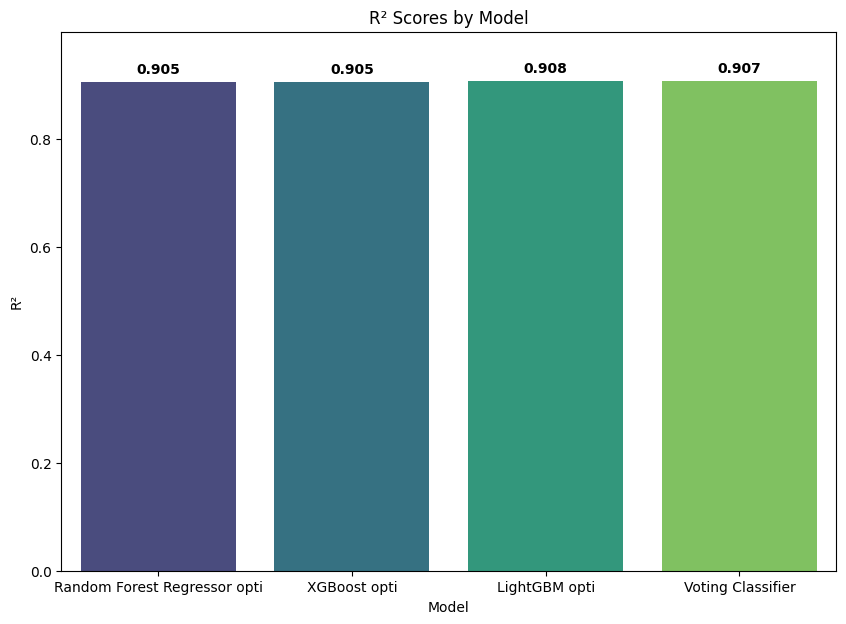

In [279]:
# Create the bar plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(
    x='Model',
    y='r2',
    data=opti_results,
    palette='viridis'
)

# Annotate bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontweight='bold'
    )

# Labels and title
plt.title('R² Scores by Model')
plt.xlabel('Model')
plt.ylabel('R²')
plt.ylim(0, 1.1 * opti_results['r2'].max())

plt.show()
